# Resumes Parsing and Natural Language Processing (NLP)
* Aurthor: Tommy Lam
* Date: 15 Mar 2020

PDF, one of the famous formats of documents, at the same time it is also a nightmare to us while we want to convert them into text format. They look like usual documents when we read them. However, they feel like pictures when we need to edit or convert them into text.

This project firstly provides a way to parse read these notorious pdf files and convert them into text format. Around 850 resumes are used to illustrate the pdf parsing. 
After the conversion, basic NLP (natural language processing) is used to investigate what is the most common topics/skills are included among the resumes.

Data for this study is one of the resources from my master degree at Monash University. The data is a huge set of resume in pdf format, same as those we have seen in our daily live or online. Therefore, any resumes can also be used in this project. 

This project is useful for those who need to handle a huge amount of text information such as HR handling more than 200 resumes, researchers studying linguistics, artificial intelligence to learn languages and so on.

## Required Libraries

In [1]:
# data processing
import pandas as pd
import numpy as np

In [2]:
# text processing
import re 
import nltk
from nltk.collocations import *
from nltk.stem import *
from nltk.stem.porter import *

In [3]:
# visualisation
import seaborn as sns #basic charts
import matplotlib.pyplot as plt #plot setup
from wordcloud import WordCloud #word cloud

In [4]:
# PDF parsing
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage

In [5]:
# miscellaneous 
import io
import os

## Read the pdf documents

1. Define a function to extract pdf file type
 * Expected input: pdf file path
 * Output: text in the pdf file 

Note: This is the basic usage of this library to obtain the text content assuming the pdf are in plain format. There are actually various kinds of pdf's features can be captured by this library such as Layout Analysis to identify the layout of pdf or obtaining table of contents. We can find more details of the PDFmniner on their page: https://pdfminer-docs.readthedocs.io/programming.html.


In [6]:
def extract_text_from_pdf(pdf_path):
    resource_manager = PDFResourceManager()
    temporary_file = io.StringIO() # Text content will be included in this object
    converter = TextConverter(resource_manager, temporary_file) 

    # check if the pdf path is workable
    try:
        page_interpreter = PDFPageInterpreter(resource_manager, converter)
    except:
        print(pdf_path + ' is not working.')

    # open the file and read the pdf
    with open(pdf_path, 'rb') as fh:
        for page in PDFPage.get_pages(fh, 
                                      caching=True,
                                      check_extractable=True):
            page_interpreter.process_page(page)
            
        text = temporary_file.getvalue()
    
    # close open handles
    converter.close()
    temporary_file.close()
    
    if text:
        return text

Here, we will parse all pdf documents in a designated file location. Therefore, firstly, we will list all files availble in the directory.

In [7]:
import os # List all files in a directory using os.listdir

basepath = 'data/resume/'
name_list = []
for entry in os.listdir(basepath):
    if os.path.isfile(os.path.join(basepath, entry)):
        name_list.append(entry)
name_list.sort() # sort the file names

In [8]:
print('There are '+str(len(name_list))+' documents available in this location')
print('First five documents:')
for i in name_list[0:5]: 
    print(' - '+i)

There are 863 documents available in this location
First five documents:
 - resume_(1).pdf
 - resume_(10).pdf
 - resume_(100).pdf
 - resume_(101).pdf
 - resume_(102).pdf


Now, read the documents into a list

In [9]:
%%time
# read documents as texts in a list 
documents = []
for each in name_list:
    documents.append(extract_text_from_pdf('data/resume/'+each))

CPU times: user 4min 41s, sys: 4.89 s, total: 4min 46s
Wall time: 5min 6s


## Tokenization
Tokenization is one of the big steps when we start to analysis text contents. This process breaks every sentences, paragraphs, passage into single words (we called them tokens). For example, 'Data science is the future' is tokenized into a bag of words 'Data','science','is','the','future'. 

We can do this by library re to split the sentences manually or using tokenize function built-in library nltk.

Note: For nltk library, some machines may require to download the 'punkt' file before performing tokenization.

In [10]:
%%time
# convert each text of documents into tokens (tokenize)
# nltk.download('punkt') 
doc_token  = [nltk.word_tokenize(doc) for doc in documents]

CPU times: user 6.11 s, sys: 138 ms, total: 6.25 s
Wall time: 6.52 s


## Normalization
There are some procedures we can do in order to enhance the performance of NLP, we called them normalization.

For example: 
1. Tokens are all turned to lower case, to avoid 'Apple' is not to 'apple' situation.
2. All tokens with length less than 3 are removed since those with less than 3 alphabets can not provide much information in this scenario. Of course, this depends on the kinds of documents we are studying and the contexts we are interested in.
3. Numerical tokens are also removed
4. Tokens are in the stopwords list are also removed (explain in the following)

#### Stopwords: 
* Stopwords are those commonly used words (such as 'the','a','an'). These words are mostly ignored in the search engine. We can assume that these stopwords are less related to the context we interested in, i.e. job application. 
* There are numerous sets of stopwords available online. In this project, the following one will be adopted: http://www.lextek.com/manuals/onix/stopwords1.html

In [11]:
## read stopwords
file = open("data/stopwords.txt", "r") 
readline = file.readlines()
stopwords = [each[0:-1] for each in readline]
print('Number of stopwords: '+str(len(stopwords)))

Number of stopwords: 429


In [12]:
### Define a function to normalise tokens
# expected input: list of tokens
# output: list of normalised tokens

def normalise(token_input):
    token_set = set()

    ## lowercase, remove token with length less than 3 and non-numeric and those in stopwords
    token_lower = [each.lower() for each in token_input]

    #remove length < 3 and non-numeric
    token_len = [each for each in token_lower if (len(each)>2 and re.match("[a-z|A-Z]",each) != None)]

    #remove those in stopwords
    token_stop = [each for each in token_len if each not in stopwords]

    return token_stop

In [13]:
%%time
token_normalised = [normalise(each) for each in doc_token]

CPU times: user 3.32 s, sys: 67.4 ms, total: 3.39 s
Wall time: 3.54 s


## Popular words in resumes
So what are the popular mentions among all these resumes? Will they be meaningful words? Are they skills related or experience related?

Alright, now we are building dataframe to count the occurrence of the words appearing in the documents.

First, a 'dictionary' containing the set of the token without repeating is built.

In [15]:
# create a function to check the count and return a list
def check_count_list(token_input): 
    # input: list of documents in form of list of tokens [[token,...],[token,..],..]
    # output: dataframe with checking items and counts
    
    # join all the token lists to create a full 'token dictionary'. 
    # convert to set such that duplicates would be removed
    token_dictionary = list(sorted(set(sum(token_input,[]))))
    count_list = [0]* len(token_dictionary)
    
    # iterate through the dataset and count the token one by one
    for i in range(0,len(token_dictionary)):
        for j in range(0,len(token_input)):
            if token_dictionary[i] in token_input[j]:
                count_list[i] += 1
    
    #create a pd to store the dictionary and counts
    token_count = pd.DataFrame({'token': token_dictionary})
    token_count['Count'] = count_list
    token_count = token_count.sort_values('Count',ascending=False).reset_index(drop =True)
    
    return token_count           


In [19]:
%%time
token_count_df = check_count_list(token_normalised)

CPU times: user 2min 27s, sys: 1.64 s, total: 2min 29s
Wall time: 2min 30s


In [20]:
token_count_df.head(10)

,token,Count
0,management,769
1,university,752
2,experience,751
3,financial,720
4,education,705
5,business,701
6,team,655
7,english,639
8,skills,610
9,finance,592


Let's visualise them in a bar chart.

In [584]:
def top_item_barplot(df,x_label,y_label,top):
    plt.figure(figsize=(7,7))
    chart = sns.barplot( x= x_label, y = y_label,data = df[0:top])

    # add value label
    for index, row in df[0:top].iterrows():
        perc = str(round(row.Count/len(documents)*100))+'%'
        chart.text( row.Count,row.name,perc, color='black')
    chart

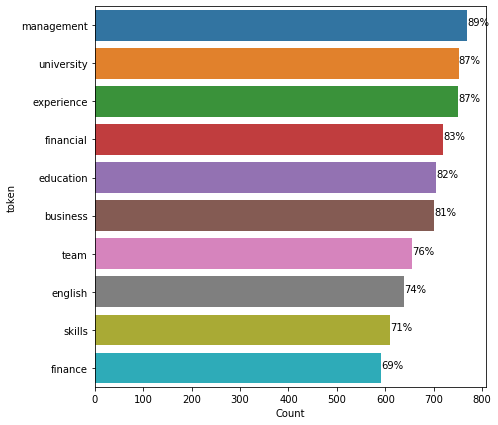

In [585]:
top_item_barplot(token_count_df,'Count','token',10)

Among the top mentions,'university','experience' and 'skiils' are expected since they are the categories that we usually put in a resume. 

## Bigram analysis
Bigram is a sequence of words with adjacent elements from sentences or tokens. For example, a sequence of 'extensive financial experience' will become 'extensive financial' and 'financial experience'. We believe the combination of words such as bigram or more (we called n-gram) gives more insights than just tokens (unigram).

Bigram can be easily built by nltk.bigrams function. They are stored in the form of a list of tuples.

In [23]:
doc_bigram = [list(nltk.bigrams(each))for each in token_normalised]
print(doc_bigram[1][1:5])

[('lapaire', 'date'), ('date', 'birth'), ('birth', 'april'), ('april', 'nationality')]


Let's count the occurrence of bigrams in documents.

Similar to unigram, we will first build a bigram dictionary and scan them through each document to check the occurrence.

In [25]:
%%time
bigram_count_df = check_count_list(doc_bigram)

CPU times: user 39min 15s, sys: 13.5 s, total: 39min 29s
Wall time: 40min 3s


Due to the fact that bigrams are built from the combination of monogram, the list of bigrams is much longer than that of monograms. Therefore, it takes almost 20 times longer to scan through all documents.

In [30]:
bigram_count_df['label'] = bigram_count_df.token.apply(lambda x: x[0]+' '+x[1])
bigram_count_df.head(5)

,token,Count,label
0,"(hong, kong)",368,hong kong
1,"(financial, statements)",274,financial statements
2,"(due, diligence)",259,due diligence
3,"(private, equity)",250,private equity
4,"(microsoft, office)",243,microsoft office


From the following bar chart showing the occurance of bigrams, it gives much more information of the documents than the monogram chart.

We can observe that these 850 resumes are highly related to Hong Kong and they are mostly related to financial business as those in the top mentions are financial terms.

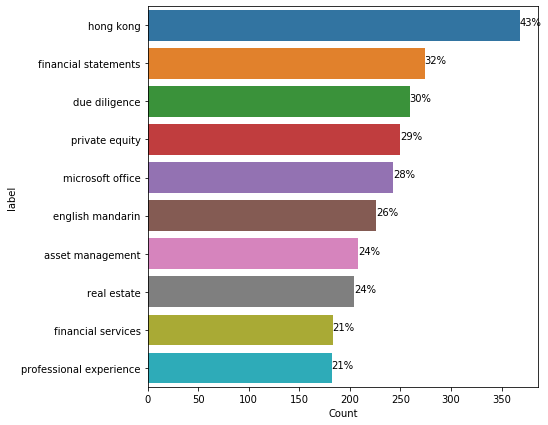

In [587]:
top_item_barplot(bigram_count_df,'Count','label',10)

## Word Cloud visualisation

In this section I will demonstrate a famous tool to visualise text data, Word Cloud. Word cloud visualises the text with larger size with high occurances and locates the words with similar pattern together such as the 'hong'+'kong' and 'financial'+'statement' in the following word cloud.

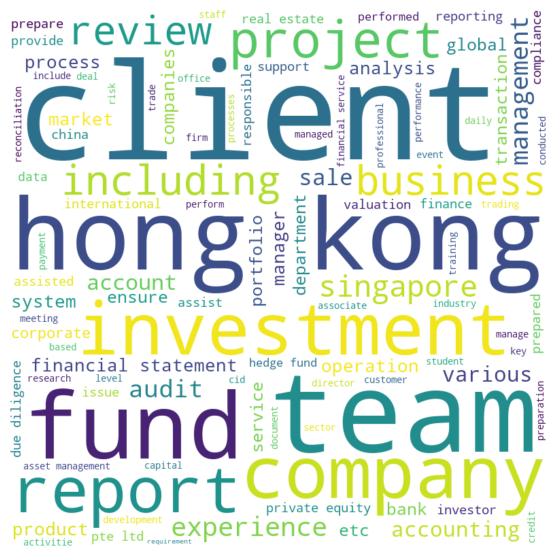

CPU times: user 7.19 s, sys: 1.08 s, total: 8.27 s
Wall time: 8.44 s


In [25]:
%%time
# Word cloud for tokens
 
# Create a list of word
text=' '.join(sum(token_normalised,[]))
 
# Create the wordcloud object
wordcloud = WordCloud(width=800, height=800, margin=10
                      , max_words=100
                      , background_color="white").generate(text)
 
# Display the generated image:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


## Stemming
 Some of you may observe that there are similar words in the top monogram chart, i.e. 'financial' vs 'finance'. These are the words sharing the same root. When we try to stem the token, which means convert them into basic form. (in this case, 'financial' and 'finance' into 'financ')

* Stemming is actually one of processes in the normalisation. In the previous section, I excluded the stemming process such that the bar chart and word cloud are showing full tokens instead of stemmed one.

* Stemmed tokens perform better when we need to further analyse the text data in classification / sentimental analysis.

Stemming can be done by using stem.porter from NLTK library.

In [36]:
##Stemming
from nltk.stem import *
from nltk.stem.porter import *
stemmer = PorterStemmer()
stemmed_token = [stemmer.stem(each) for each in token_count_df.token]
stemmed_token = list(set(stemmed_token))
stemmed_token.sort()
print('Number of tokens before stemming: '+str(len(token_count_df.token))) #before stemming
print('Number of tokens after stemming: '+str(len(stemmed_token))) #after stemming
print('')
print(str(len(token_count_df.token) - len(stemmed_token)) +' tokens are reduced after stemming')

Number of tokens before stemming: 26011
Number of tokens after stemming: 21145

4866 tokens are reduced after stemming


In [37]:
### Define a function to stem the tokens in list

def stemming(token_input):
    # expected input: tokens in a list
    # output: stemmed tokens in the same list
    ## lowercase, remove token with length less than 3 and non-numeric and those in stopwords
    token_stemmed = [stemmer.stem(each) for each in token_input]

    return token_stemmed

In [38]:
token_stemmed = [stemming(each) for each in token_normalised]

In [42]:
%%time
token_stemmed_count_df = check_count_list(token_stemmed)

CPU times: user 1min 58s, sys: 1.03 s, total: 1min 59s
Wall time: 1min 59s


In [43]:
token_stemmed_count_df.head()

,token,Count
0,manag,819
1,experi,790
2,univers,756
3,educ,733
4,financi,723


Let's visualise them in a bar chart.

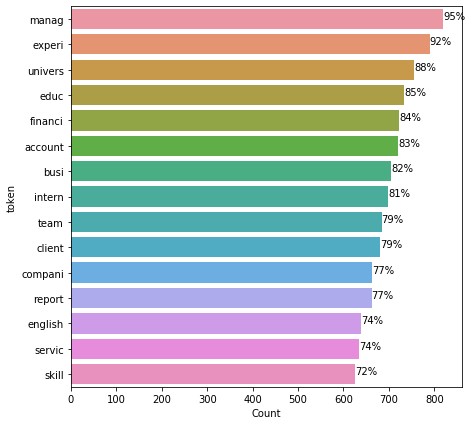

In [588]:
top_item_barplot(token_stemmed_count_df,'Count','token',15)

After stemming, we can observe that 95% of the resumes include the keywords related to manage and finance (excluding experience/university/education).

## Criteria Filtering
Since there are 850+ resumes, we can develop a filter to select some of them with the critieria we need.

For example, I would like to find out those with experience in finance and marketing in Australia, with position at least manager level and with a master's degree. We can launch a filter based on the keywords as followed:

In [206]:
criteria = ['finance','marketing','australia','manager','master']

Firstly, we can create a data frame storing the information of documents name and tokens. We can check whether if the documents contain the keywords we are searching for.

In [207]:
criteria_filtering = pd.DataFrame({'documents': name_list, 'tokens':token_normalised}) 

Apply function is used to iterate through all the text documents to check whether each of the text carries the keywords we are searching for.
A new column 'filter' is defined to record the number of keywords matched for each of the text doument.

In [329]:
# create a list to count the occurances of filtering words
filter_list = list()

for each in criteria:
    filter_list.append(np.array(criteria_filtering.tokens.apply(lambda x : 1 if each in x else 0)))

# aggregate the results by sum
criteria_filtering['filter'] = sum(filter_list)

We can filter and select the documents based on the number of keywords matched.

In [209]:
criteria_filtering[criteria_filtering['filter'] >= len(filtering)]

,documents,tokens,filter
100,resume_(19).pdf,"[takorn, ohm, khempila, tkhempila, gmail.com, ...",5
367,resume_(43).pdf,"[tan, keng, tiong, block, bishan, street, sing...",5
530,resume_(579).pdf,"[cherry, zhu, cherryzhu, gmail.com, summary, q...",5
652,resume_(689).pdf,"[page, page, wai, maggie, phone, e-mail, maggi...",5
736,resume_(765).pdf,"[benjamin, lindsay, synopsis, cid:1, articulat...",5
801,resume_(823).pdf,"[dear, sir/madam, qualified, accountant, hong,...",5


So now we are able to obtain the subset the data by filtering the keywords we want.

### Optimisation
The next step is to make it more user-friendly.
We can put the filtering codes together into a function and allow us to input the percentage of matching as well.

* Expected input: 
    1. keywords
    2. percentage match
* Output: 
    * Name of the doucments matching the keywords with certain percentage

In [339]:
def filtering_documents(filter_words,percentage_match = None):
    
    # Find the percentage match. Default 100% match if not specified.
    if not percentage_match:
        percentage_match = len(filter_words)
    
    # create a dataframe to store the information and a list to count the occurances of filtering words 
    criteria_filtering = pd.DataFrame({'documents': name_list, 'tokens':token_normalised}) 
    filter_list = list()

    # iterate through the documents to check the counts of filtering keywords
    for each in filter_words:
        filter_list.append(np.array(criteria_filtering.tokens.apply(lambda x : 1 if each.lower() in x else 0)))

    # aggregate the results by sum
    criteria_filtering['filter'] = sum(filter_list)
    
    # obtain the subset of dataframe after filtering
    criteria_filtering = criteria_filtering[criteria_filtering['filter'] >= percentage_match*len(filter_words)/100]
    
    # return "None" if none are match
    if len(criteria_filtering) == 0:
        return ['None']
    else:
        return list(criteria_filtering['documents']) #return the list of document names

For example, we would like to search for the candidates with certain industries, education, location, positions and experience among 850+ resumes.

In [350]:
keywords = ['Finance','Marketing', #industry
            'master', #education
            'Australia', #location
            'Manager','Director','Analyst', #positions
            'analysis','fund','client'] #experience

In [351]:
print('100% match:')
for each in filtering_documents(keywords,100): print(each)
print('-------------------')
print('90% match:')
for each in filtering_documents(keywords,90): print(each)


100% match:
resume_(579).pdf
-------------------
90% match:
resume_(19).pdf
resume_(43).pdf
resume_(579).pdf
resume_(765).pdf


## Unsupervised classification - K-mean clustering
K-mean clustering is one of the famous classification methods to partition the data into K clusters based on their similarities among the data.

1. Top stemmed words
2. Build DTM based on the top words
3. insert to Kmean

We will use the top 50 frequent stemmed tokens as the features to perform clustering.
Before we run the Kmean algorithm, we will first create a DTM (document-term matrix) that describes the frequency of terms that occur in a collection of documents. In the DTM, the row corresponds to documents in our collection and the column corresponds to the features terms (Top 50 frequent stemmed tokens in this case).

In [563]:
top = 50
top_stemmed = list(token_stemmed_count_df[0:top].token) 

In [564]:
%%time
# create DTM
vector_count = list()
for text in token_stemmed:
    count_list = [0]* len(top_stemmed)
    for i in range(0,len(top_stemmed)):
        for each_token in text:
            if top_stemmed[i] == each_token:
                count_list[i] +=1    
    vector_count.append(np.array(count_list))

CPU times: user 2.23 s, sys: 20.4 ms, total: 2.25 s
Wall time: 2.35 s


Based on the DTM, we can create a TF-IDF (short for term frequency-Inverse document frequency) which is a weighting conversion of DTM such that it can reflect the the importance of word in a more effective way. TF-IDF is common used by search engines, stop-words filtering, text summarisation and classification.

In [565]:
# create tfidf
def t(x): return np.transpose(x)

df = np.array(vector_count)
N = np.array([len(each) for each in token_stemmed])
# tf = (np.array(vector_count))* (1/N)
tf = t(t(df)/N)
tfidf = np.log(t(N / t(df + 1))) *tf

Run the Kmean classifcation by in-built KmeansClusterer in nltk package:

In [569]:
%%time
# Run Kmean classification
from nltk.cluster import KMeansClusterer, euclidean_distance
clusterer = KMeansClusterer(2, euclidean_distance, repeats=10)
clusters = clusterer.cluster(np.array(tfidf), True, trace=False)


CPU times: user 1.26 s, sys: 15 ms, total: 1.28 s
Wall time: 1.34 s


In [634]:
doc_cluster = pd.DataFrame({'name':name_list,'token':token_normalised,'stemmed_token':token_stemmed,'cluster':clusters})
doc_cluster.head(10)

,name,token,stemmed_token,cluster
0,resume_(1).pdf,"[curriculum, vitae, mail, vgowribalan, gmail.c...","[curriculum, vita, mail, vgowribalan, gmail.co...",0
1,resume_(10).pdf,"[laurent, lapaire, date, birth, april, nationa...","[laurent, lapair, date, birth, april, nation, ...",0
2,resume_(100).pdf,"[chin, kwok, chinkhthomas, gmail.com, educatio...","[chin, kwok, chinkhthoma, gmail.com, educ, hon...",1
3,resume_(101).pdf,"[novita, lam, cellular, email, address, novita...","[novita, lam, cellular, email, address, novita...",0
4,resume_(102).pdf,"[erica, tel, email, erica_pyyu, hotmail.com, a...","[erica, tel, email, erica_pyyu, hotmail.com, a...",0
5,resume_(103).pdf,"[yulong, brian, cfa, eunos, crescent, singapor...","[yulong, brian, cfa, euno, crescent, singapor,...",0
6,resume_(104).pdf,"[curriculum, vitae, page, rebecca, andersen, l...","[curriculum, vita, page, rebecca, andersen, ll...",0
7,resume_(105).pdf,"[page, sum, peiling, patricia, address, block,...","[page, sum, peil, patricia, address, block, de...",1
8,resume_(106).pdf,"[wong, kit, kaye-mail, wongmankit1982, gmail.c...","[wong, kit, kaye-mail, wongmankit1982, gmail.c...",0
9,resume_(107).pdf,"[yuko, takahata, rochester, drive, singapore, ...","[yuko, takahata, rochest, drive, singapor, yuu...",0


Next, we can now create a counting table for the tokens in each of the cluster subsets.

In [595]:
%%time
cluster_1 = check_count_list(list(doc_cluster[doc_cluster.cluster == 0].token))
cluster_2 = check_count_list(list(doc_cluster[doc_cluster.cluster == 1].token))

CPU times: user 2min 10s, sys: 1.42 s, total: 2min 12s
Wall time: 2min 14s


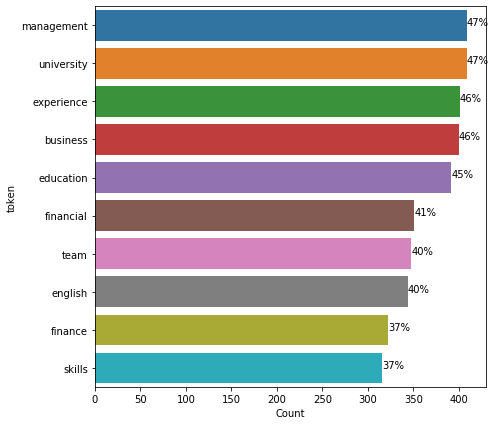

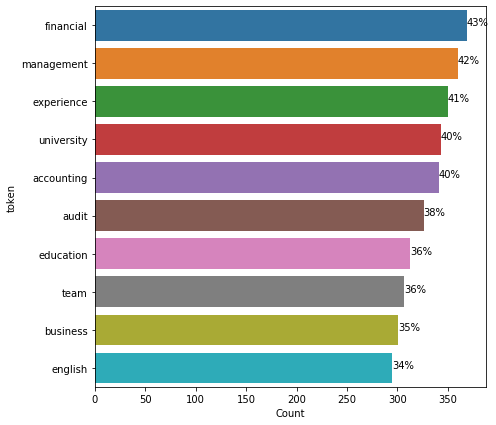

In [632]:
top_item_barplot(cluster_1,'Count','token',10)
top_item_barplot(cluster_2,'Count','token',10)

We can see that the candidates in Cluster 1 possess more skills and experience in accounting and audit aspect; while those in Cluster 2 are more related to business, team and management, relating to senior management position with handling teams situation.

## Summary
* By using PDFminer, we can parse the pdf file into text contents. 
* With the basic Natural Language Processing, the text contents are further tokenised and formed bigrams.
* Word cloud can be used to visualise the text pattern effectively.
* We can further develop different types of application based on the NLP we have performed on the text data.
* K-mean clustering can partition the resumes into different clusters. Each clusters may carry different characteristics based the input we used in the model.